/home/juanjo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


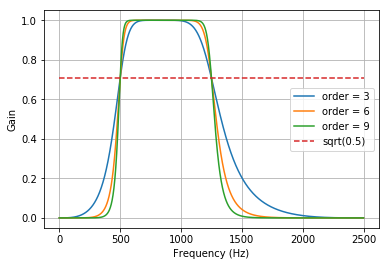

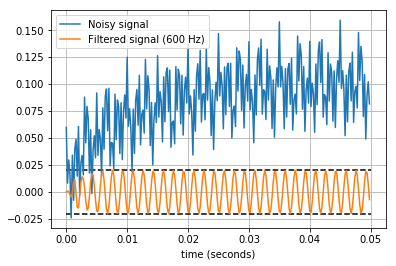

In [2]:
%matplotlib inline

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()


run()

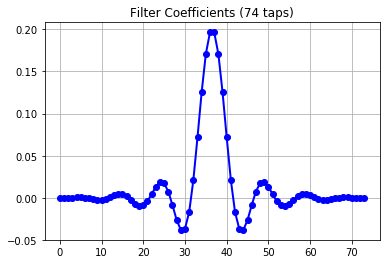

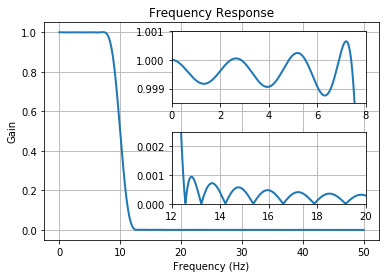

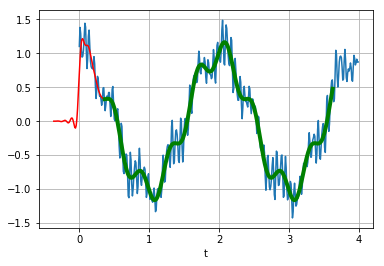

In [3]:
%matplotlib inline

from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show


#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 100.0
nsamples = 400
t = arange(nsamples) / sample_rate
x = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)


#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------

figure(1)
plot(taps, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % N)
grid(True)

#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

figure(2)
clf()
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, x)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, filtered_x, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()

Did np.convolve and lfilter produce the same results?
Yes.
Did fftconvolve and lfilter produce the same results?
Yes.
Did convolve1d and lfilter produce the same results?
Yes.


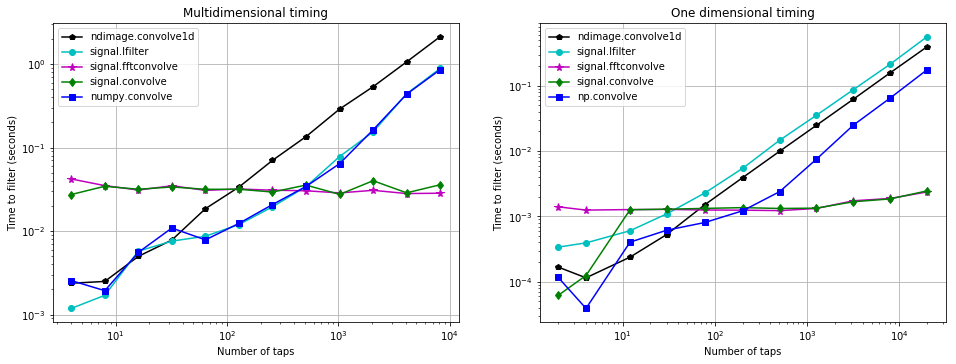

In [4]:
%matplotlib inline
from __future__ import print_function
import time

import numpy as np
from numpy import convolve as np_convolve
from scipy.signal import fftconvolve, lfilter, firwin
from scipy.signal import convolve as sig_convolve
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

# Create the m by n data to be filtered.
m = 1
n = 2 ** 18
x = np.random.random(size=(m, n))

conv_time = []
npconv_time = []
fftconv_time = []
conv1d_time = []
lfilt_time = []

diff_list = []
diff2_list = []
diff3_list = []

ntaps_list = 2 ** np.arange(2, 14)

for ntaps in ntaps_list:
    # Create a FIR filter.
    b = firwin(ntaps, [0.05, 0.95], width=0.05, pass_zero=False)

    # --- signal.convolve ---
    tstart = time.time()
    conv_result = sig_convolve(x, b[np.newaxis, :], mode='valid')
    conv_time.append(time.time() - tstart)

    # --- numpy.convolve ---
    tstart = time.time()
    npconv_result = np.array([np_convolve(xi, b, mode='valid') for xi in x])
    npconv_time.append(time.time() - tstart)

    # --- signal.fftconvolve ---
    tstart = time.time()
    fftconv_result = fftconvolve(x, b[np.newaxis, :], mode='valid')
    fftconv_time.append(time.time() - tstart)

    # --- convolve1d ---
    tstart = time.time()
    # convolve1d doesn't have a 'valid' mode, so we expliclity slice out
    # the valid part of the result.
    conv1d_result = convolve1d(x, b)[:, (len(b)-1)//2 : -(len(b)//2)]
    conv1d_time.append(time.time() - tstart)

    # --- lfilter ---
    tstart = time.time()
    lfilt_result = lfilter(b, [1.0], x)[:, len(b) - 1:]
    lfilt_time.append(time.time() - tstart)

    diff = np.abs(fftconv_result - lfilt_result).max()
    diff_list.append(diff)

    diff2 = np.abs(conv1d_result - lfilt_result).max()
    diff2_list.append(diff2)

    diff3 = np.abs(npconv_result - lfilt_result).max()
    diff3_list.append(diff3)

# Verify that np.convolve and lfilter gave the same results.
print("Did np.convolve and lfilter produce the same results?",)
check = all(diff < 1e-13 for diff in diff3_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")

# Verify that fftconvolve and lfilter gave the same results.
print( "Did fftconvolve and lfilter produce the same results?")
check = all(diff < 1e-13 for diff in diff_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")

# Verify that convolve1d and lfilter gave the same results.
print( "Did convolve1d and lfilter produce the same results?",)
check = all(diff2 < 1e-13 for diff2 in diff2_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")
    
def timeit(fn, shape, lfilter=False, n_x=2e4, repeats=3):
    x = np.random.rand(int(n_x))
    y = np.random.rand(*shape)
    args = [x, y] if not lfilter else [x, x, y]
    times = []
    for _ in range(int(repeats)):
        start = time.time()
        c = fn(*args)
        times += [time.time() - start]
    return min(times)

npconv_time2, conv_time2, conv1d_time2 = [], [], []
fftconv_time2, sig_conv_time2, lconv_time2 = [], [], []
Ns_1d = 2*np.logspace(0, 4, num=11, dtype=int)
for n in Ns_1d:
    npconv_time2 += [timeit(np_convolve, shape=(n,))]
    conv1d_time2 += [timeit(convolve1d, shape=(n,))]
    fftconv_time2 += [timeit(fftconvolve, shape=(n,))]
    sig_conv_time2 += [timeit(sig_convolve, shape=(n,))]
    lconv_time2 += [timeit(lfilter, shape=(n,), lfilter=True)]



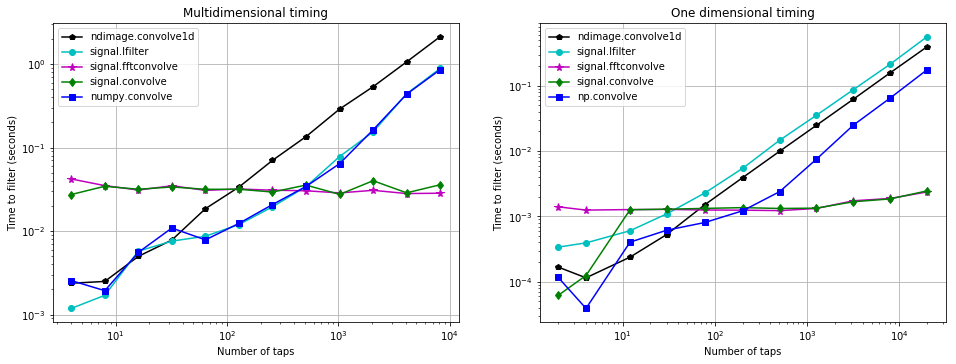

In [5]:
fig = plt.figure(1, figsize=(16, 5.5))
plt.subplot(1, 2, 1)
plt.loglog(ntaps_list, conv1d_time, 'k-p', label='ndimage.convolve1d')
plt.loglog(ntaps_list, lfilt_time, 'c-o', label='signal.lfilter')
plt.loglog(ntaps_list, fftconv_time, 'm-*', markersize=8, label='signal.fftconvolve')
plt.loglog(ntaps_list[:len(conv_time)], conv_time, 'g-d', label='signal.convolve')
plt.loglog(ntaps_list, npconv_time, 'b-s', label='numpy.convolve')
plt.legend(loc='best', numpoints=1)
plt.grid(True)
plt.xlabel('Number of taps')
plt.ylabel('Time to filter (seconds)')
plt.title('Multidimensional timing')

plt.subplot(1, 2, 2)
plt.loglog(Ns_1d, conv1d_time2, 'k-p', label='ndimage.convolve1d')
plt.loglog(Ns_1d, lconv_time2, 'c-o', label='signal.lfilter')
plt.loglog(Ns_1d, fftconv_time2, 'm-*', markersize=8, label='signal.fftconvolve')
plt.loglog(Ns_1d, sig_conv_time2, 'g-d', label='signal.convolve')
plt.loglog(Ns_1d, npconv_time2, 'b-s', label='np.convolve')
plt.grid()
plt.xlabel('Number of taps')
plt.ylabel('Time to filter (seconds)')
plt.title('One dimensional timing')
plt.legend(loc='best')
plt.show()